In [1]:
from cnn_builder import *
from config import *
from dataset_functions import *
from hypercube_set import HypercubeSet
from hypercube_loader import *
import numpy as np

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'
os.chdir(os.getcwd().split("jupyter")[0])

inf = 2e32

%load_ext autoreload
%autoreload 2

In [2]:
hc_set = HypercubeSet(hc_array=load_hypercubes(plot_hc=False, plot_mask=False, n_max_cubes=inf))
hc_set.print_metadata()

Reading media/Mateus_2022/Area01\raw_112_rf.hdr ...
Reading media/Mateus_2022/Area01\raw_1984_rf.hdr ...
Reading media/Mateus_2022/Area01\raw_3904_rf.hdr ...
Reading media/Mateus_2022/Area01\raw_5744_rf.hdr ...
Reading media/Mateus_2022/Area01\raw_7584_rf.hdr ...
Min: 0.006377667188644409, Max: 0.16416394710540771, Size: (1840, 3200, 223)


In [3]:
hc_set.obtain_ground_labels()
hc_set.obtain_train_indices(test_percentage=test_split, patch_size=patch_size, patch_overlapping=patch_overlapping)

In [ ]:
hc_set.standardize()

|                                        | ▇▇▅ 0/2 [0%] in 10s (~0s, 0.0/s) 

In [ ]:
X_train, y_train = hc_set.split_train(patch_size=patch_size)
y_train = reduce_labels_center(y_train)

In [ ]:
X_test, y_test = hc_set.split_test(patch_size=patch_size)
y_test = reduce_labels_center(y_test)

In [ ]:
render_mask_histogram(y_train)
render_mask_histogram(y_test)

In [ ]:
(patch, patch_label), rest_patch, rest_label = balance_classes(X_train, y_train, reduce=True, clustering=False)

In [ ]:
X_train, y_train = [], []
X_train.append(patch)
X_train.append(rest_patch)
y_train.append(patch_label)
y_train.append(rest_label)
vegetation_indices = np.where(y_train[1] == 0)
X_train[1] = np.delete(X_train[1], vegetation_indices)
y_train[1] = np.delete(y_train[1], vegetation_indices)

In [ ]:
(X_test, y_test), _, _ = balance_classes(X_test, y_test, reduce=True, clustering=False)

In [ ]:
render_mask_histogram(y_test)

In [ ]:
X_train_flatten = get_center(X_train[0])
X_train_augment, y_train_augmented = augment_chunks(X_train[0], y_train[0])

In [ ]:
network_type = 'allopezr_2d'
read_json_config(paths.config_file, network_type=network_type)

network_name = get_name(network_type)
num_classes = hc_set.get_num_classes()
img_shape = X_train[0][0].shape

model = build_network(network_type=network_type, num_classes=num_classes, image_dim=img_shape)
compile_network(model, network_type, network_name, num_classes, show_summary=True, render_image=True)
history = run_model(model, X_train_augment, y_train_augmented, validation_split=validation_split, callbacks=get_callback_list(model_name=network_name))

# Rendering and results

In [47]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss: " + str(test_loss) + ", Test Accuracy: " + str(test_accuracy))

415/415 [==============================] - 3s 6ms/step - loss: 0.1533 - sparse_categorical_accuracy: 0.9616
Test Loss: 0.1532617062330246, Test Accuracy: 0.9615819454193115


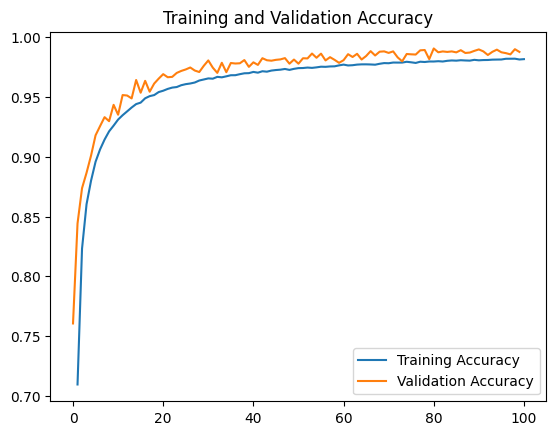

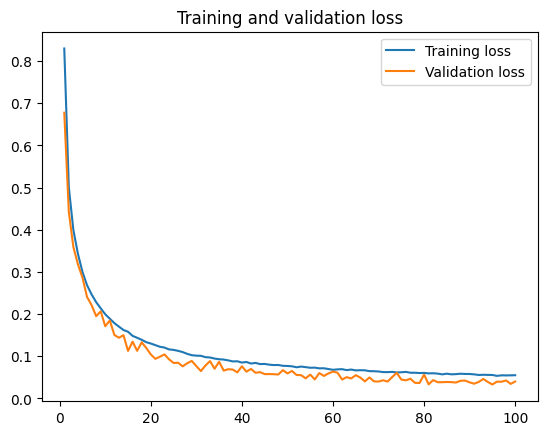

In [42]:
render_model_history(history, model_name=network_name, accuracy="sparse_categorical_accuracy")

415/415 [==============================] - 2s 4ms/step


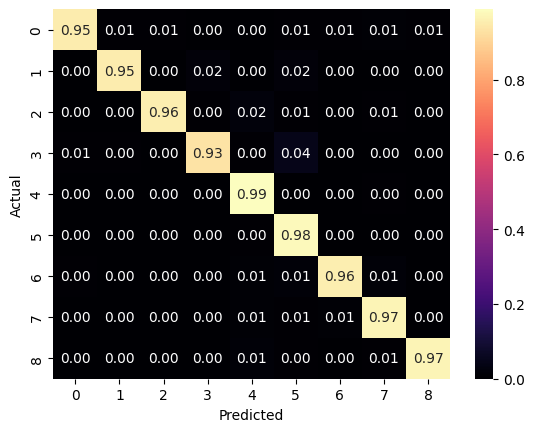

In [48]:
prediction = model.predict(X_test)
model_predictions = np.argmax(prediction, axis=1)
render_confusion_matrix(y_test, model_predictions)

3283/3283 [==============================] - 5s 1ms/step


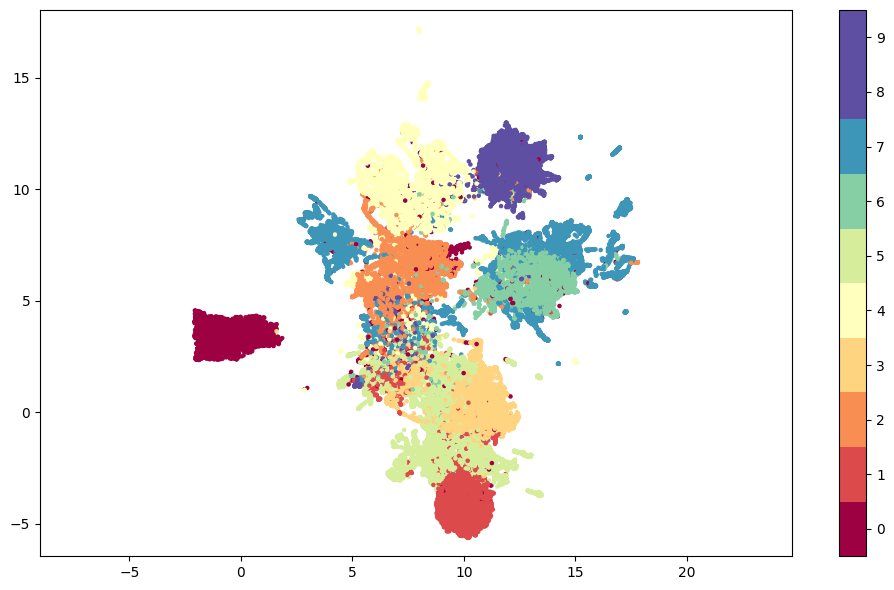

In [30]:
predict_model = keras.Model(model.input, model.layers[-2].output)
predicted_train = predict_model.predict(X_train[0])
render_umap_spectrum(predicted_train, y_train[0])

# Hypertuning

In [18]:
network_type = 'allopezr_2d'
#read_json_config(paths.config_file, network_type=network_type)

network_name = get_name(network_type)
num_classes = hc_set.get_num_classes()
img_shape = X_train[0][0].shape

# Reduce dataset
reduce_factor = 0.2
random_indices = np.random.choice(np.arange(len(X_train_augment)), int(len (X_train_augment) * reduce_factor), replace=False)

model = hypertune([X_train_augment[random_indices]], y_train_augmented[random_indices], network_type=network_type, model_name=network_name, validation_split=validation_split, callbacks=get_callback_list(model_name=network_name))

Trial 220 Complete [00h 07m 58s]
val_loss: 1.4392191171646118

Best val_loss So Far: 0.5229037404060364
Total elapsed time: 16h 12m 11s

Search: Running Trial #221

Value             |Best Value So Far |Hyperparameter
96                |32                |conv_1a
128               |16                |conv_2b
96                |16                |conv_3c
False             |False             |use_first_conv
0.0001            |0.01              |lr
0.4               |0.4               |intermediate_dropout
7                 |3                 |first_kernel_size
0.5               |0.1               |final_dropout
0.1               |0.1               |leaky_alpha
softplus          |exponential       |activation
2                 |2                 |strides
100               |34                |tuner/epochs
34                |12                |tuner/initial_epoch
2                 |4                 |tuner/bracket
2                 |3                 |tuner/round
0214              |0132    

KeyboardInterrupt: 